In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd   
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb ## XGBoost 불러오기
import itertools

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss, recall_score
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score
from sklearn.metrics import f1_score, roc_auc_score, log_loss
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from xgboost import plot_importance ## Feature Importance를 불러오기 위함
from xgboost import XGBClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier

from tensorflow.keras.utils import to_categorical

In [2]:
import os
os.chdir('../open2')

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')

In [4]:
train.describe()

,index,child_num,income_total,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,family_size,begin_month,credit
count,26457.000000,26457.000000,2.645700e+04,26457.000000,26457.000000,26457.0,26457.000000,26457.000000,26457.000000,26457.000000,26457.000000,26457.000000
mean,13228.000000,0.428658,1.873065e+05,-15958.053899,59068.750728,1.0,0.224742,0.294251,0.091280,2.196848,-26.123294,1.519560
std,7637.622372,0.747326,1.018784e+05,4201.589022,137475.427503,0.0,0.417420,0.455714,0.288013,0.916717,16.559550,0.702283
min,0.000000,0.000000,2.700000e+04,-25152.000000,-15713.000000,1.0,0.000000,0.000000,0.000000,1.000000,-60.000000,0.000000
25%,6614.000000,0.000000,1.215000e+05,-19431.000000,-3153.000000,1.0,0.000000,0.000000,0.000000,2.000000,-39.000000,1.000000
50%,13228.000000,0.000000,1.575000e+05,-15547.000000,-1539.000000,1.0,0.000000,0.000000,0.000000,2.000000,-24.000000,2.000000
75%,19842.000000,1.000000,2.250000e+05,-12446.000000,-407.000000,1.0,0.000000,1.000000,0.000000,3.000000,-12.000000,2.000000
max,26456.000000,19.000000,1.575000e+06,-7705.000000,365243.000000,1.0,1.000000,1.000000,1.000000,20.000000,0.000000,2.000000


In [5]:
train.head()

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
0,0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,1,0,0,0,NaN,2,-6,1
1,1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,1,0,0,1,Laborers,3,-5,1
2,2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,-19087,-4434,1,0,1,0,Managers,2,-22,2
3,3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15088,-2092,1,0,1,0,Sales staff,2,-37,0
4,4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,-15037,-2105,1,0,0,0,Managers,2,-26,2


In [6]:
test.head()

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month
0,26457,M,Y,N,0,112500.0,Pensioner,Secondary / secondary special,Civil marriage,House / apartment,-21990,365243,1,0,1,0,NaN,2.0,-60.0
1,26458,F,N,Y,0,135000.0,State servant,Higher education,Married,House / apartment,-18964,-8671,1,0,1,0,Core staff,2.0,-36.0
2,26459,F,N,Y,0,69372.0,Working,Secondary / secondary special,Married,House / apartment,-15887,-217,1,1,1,0,Laborers,2.0,-40.0
3,26460,M,Y,N,0,112500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-19270,-2531,1,1,0,0,Drivers,2.0,-41.0
4,26461,F,Y,Y,0,225000.0,State servant,Higher education,Married,House / apartment,-17822,-9385,1,1,0,0,Managers,2.0,-8.0


In [7]:
train.shape

(26457, 20)

In [8]:
test.shape

(10000, 19)

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26457 entries, 0 to 26456
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          26457 non-null  int64  
 1   gender         26457 non-null  object 
 2   car            26457 non-null  object 
 3   reality        26457 non-null  object 
 4   child_num      26457 non-null  int64  
 5   income_total   26457 non-null  float64
 6   income_type    26457 non-null  object 
 7   edu_type       26457 non-null  object 
 8   family_type    26457 non-null  object 
 9   house_type     26457 non-null  object 
 10  DAYS_BIRTH     26457 non-null  int64  
 11  DAYS_EMPLOYED  26457 non-null  int64  
 12  FLAG_MOBIL     26457 non-null  int64  
 13  work_phone     26457 non-null  int64  
 14  phone          26457 non-null  int64  
 15  email          26457 non-null  int64  
 16  occyp_type     18286 non-null  object 
 17  family_size    26457 non-null  int64  
 18  begin_

# 데이터전처리

In [10]:
#결측치 제거
train.isnull().sum()

index               0
gender              0
car                 0
reality             0
child_num           0
income_total        0
income_type         0
edu_type            0
family_type         0
house_type          0
DAYS_BIRTH          0
DAYS_EMPLOYED       0
FLAG_MOBIL          0
work_phone          0
phone               0
email               0
occyp_type       8171
family_size         0
begin_month         0
credit              0
dtype: int64

In [11]:
train=train.drop('occyp_type', axis=1)
test=test.drop('occyp_type', axis=1)

In [12]:
#이진분류
train['gender'] = train['gender'].replace(['F','M'],[0,1])
test['gender'] = test['gender'].replace(['F','M'],[0,1])
print('성별 :')
print(train['gender'].value_counts())
print('--------------')

print('차량 소유여부 : ')
train['car'] = train['car'].replace(['N','Y'],[0,1])
test['car'] = test['car'].replace(['N','Y'],[0,1])
print(train['car'].value_counts())
print('--------------')

print('자가 소유여부: ')
train['reality'] = train['reality'].replace(['N','Y'],[0,1])
test['reality'] = test['reality'].replace(['N','Y'],[0,1])
print(train['reality'].value_counts())
print('--------------')
      
print('전화기 소유여부: ')
print(train['phone'].value_counts())
print('--------------')
      
print('이메일 소유여부: ')
print(train['email'].value_counts())
print('--------------')
      
print('업무용 핸드폰 소유여부: ')
print(train['work_phone'].value_counts())
print('--------------')

성별 :
0    17697
1     8760
Name: gender, dtype: int64
--------------
차량 소유여부 : 
0    16410
1    10047
Name: car, dtype: int64
--------------
자가 소유여부: 
1    17830
0     8627
Name: reality, dtype: int64
--------------
전화기 소유여부: 
0    18672
1     7785
Name: phone, dtype: int64
--------------
이메일 소유여부: 
0    24042
1     2415
Name: email, dtype: int64
--------------
업무용 핸드폰 소유여부: 
0    20511
1     5946
Name: work_phone, dtype: int64
--------------


# 연속형 수치 분류

<AxesSubplot:>

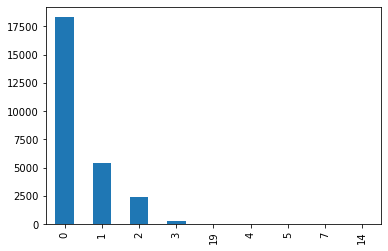

In [13]:
train['child_num'].value_counts(sort=False).plot.bar()

In [14]:
train.loc[train['child_num'] >= 2,'child_num']=2
test.loc[test['child_num']>=2, 'child_num']=2

(2.544, 18.18]      16212
(18.18, 33.66]       8330
(33.66, 49.14]       1530
(49.14, 64.62]        206
(64.62, 80.1]         121
(80.1, 95.58]          44
(95.58, 111.06]         3
(111.06, 126.54]        2
(126.54, 142.02]        4
(142.02, 157.5]         5
Name: income_total, dtype: int64


<AxesSubplot:ylabel='Frequency'>

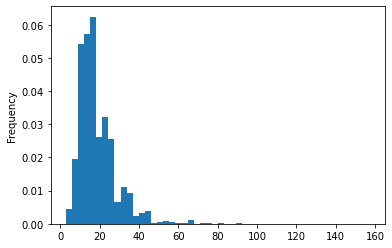

In [15]:
train['income_total'] = train['income_total'].astype(object)
train['income_total'] = train['income_total']/10000 
test['income_total'] = test['income_total']/10000

print(train['income_total'].value_counts(bins=10,sort=False))
train['income_total'].plot(kind='hist',bins=50,density=True)

In [16]:
count, bin_dividers =np.histogram(train['income_total'], bins=7)
bin_names=['소득'+str(i) for i in range(7) ]
train['income_total']=pd.cut(x=train['income_total'], bins=bin_dividers, labels=bin_names, include_lowest=True)
test['income_total']=pd.cut(x=test['income_total'], bins=bin_dividers, labels=bin_names, include_lowest=True)

In [17]:
test

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,family_size,begin_month
0,26457,1,1,0,0,소득0,Pensioner,Secondary / secondary special,Civil marriage,House / apartment,-21990,365243,1,0,1,0,2.0,-60.0
1,26458,0,0,1,0,소득0,State servant,Higher education,Married,House / apartment,-18964,-8671,1,0,1,0,2.0,-36.0
2,26459,0,0,1,0,소득0,Working,Secondary / secondary special,Married,House / apartment,-15887,-217,1,1,1,0,2.0,-40.0
3,26460,1,1,0,0,소득0,Commercial associate,Secondary / secondary special,Married,House / apartment,-19270,-2531,1,1,0,0,2.0,-41.0
4,26461,0,1,1,0,소득0,State servant,Higher education,Married,House / apartment,-17822,-9385,1,1,0,0,2.0,-8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,36452,0,1,1,0,소득0,Working,Incomplete higher,Married,House / apartment,-18593,-5434,1,1,1,0,2.0,-19.0
9996,36453,1,1,1,0,소득0,Working,Secondary / secondary special,Civil marriage,House / apartment,-10886,-1315,1,1,0,0,2.0,-34.0
9997,36454,0,0,1,0,소득1,Working,Secondary / secondary special,Married,House / apartment,-21016,-14018,1,0,0,0,2.0,-55.0
9998,36455,0,1,0,0,소득0,Commercial associate,Secondary / secondary special,Married,House / apartment,-16541,-1085,1,0,1,0,2.0,-33.0


In [18]:
print(train['income_type'].unique())
print(train['edu_type'].unique())
print(train['family_type'].unique())
print(train['house_type'].unique())

['Commercial associate' 'Working' 'State servant' 'Pensioner' 'Student']
['Higher education' 'Secondary / secondary special' 'Incomplete higher'
 'Lower secondary' 'Academic degree']
['Married' 'Civil marriage' 'Separated' 'Single / not married' 'Widow']
['Municipal apartment' 'House / apartment' 'With parents'
 'Co-op apartment' 'Rented apartment' 'Office apartment']


In [19]:
from sklearn import preprocessing
label_encoder=preprocessing.LabelEncoder()
train['income_type']=label_encoder.fit_transform(train['income_type'])
test['income_type']=label_encoder.transform(test['income_type'])

train['edu_type']=label_encoder.fit_transform(train['edu_type'])
test['edu_type']=label_encoder.transform(test['edu_type'])

train['family_type']=label_encoder.fit_transform(train['family_type'])
test['family_type']=label_encoder.transform(test['family_type'])

train['house_type']=label_encoder.fit_transform(train['house_type'])
test['house_type']=label_encoder.transform(test['house_type'])

train['income_total']=label_encoder.fit_transform(train['income_total'])
test['income_total']=label_encoder.fit_transform(test['income_total'])

In [20]:
train

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,family_size,begin_month,credit
0,0,0,0,0,0,0,0,1,1,2,-13899,-4709,1,0,0,0,2,-6,1
1,1,0,0,1,1,0,0,4,0,1,-11380,-1540,1,0,0,1,3,-5,1
2,2,1,1,1,0,1,4,1,1,1,-19087,-4434,1,0,1,0,2,-22,2
3,3,0,0,1,0,0,0,4,1,1,-15088,-2092,1,0,1,0,2,-37,0
4,4,0,1,1,0,0,2,1,1,1,-15037,-2105,1,0,0,0,2,-26,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26452,26452,0,0,0,2,0,2,4,1,1,-12079,-1984,1,0,0,0,4,-2,1
26453,26453,0,0,1,1,0,4,1,2,1,-15291,-2475,1,0,0,0,2,-47,2
26454,26454,0,1,0,0,1,4,4,0,5,-10082,-2015,1,0,0,0,2,-25,2
26455,26455,1,0,1,0,0,4,2,3,1,-10145,-107,1,0,0,0,1,-59,2


In [5]:
#음수값 변환
#minus 변경하고
#구간화 함수
def make_bin(variable, n):
    train[variable]=-train[variable]
    test[variable]=-test[variable]
    count, bin_dividers =np.histogram(train[variable], bins=n) #train의 구간화를 적용
    bin_names=[str(i) for i in range(n)]
    train[variable]=pd.cut(x=train[variable], bins=bin_dividers, labels=bin_names, include_lowest=True)
    test[variable]=pd.cut(x=test[variable], bins=bin_dividers, labels=bin_names, include_lowest=True)
    test[variable].fillna(str(0), inplace=True) #test에는 없는 것을 임의의 값으로 채움
    
    train[variable]=label_encoder.fit_transform(train[variable])
    test[variable]=label_encoder.transform(test[variable])

In [22]:
train.columns

Index(['index', 'gender', 'car', 'reality', 'child_num', 'income_total',
       'income_type', 'edu_type', 'family_type', 'house_type', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'FLAG_MOBIL', 'work_phone', 'phone', 'email',
       'family_size', 'begin_month', 'credit'],
      dtype='object')

In [23]:
make_bin('DAYS_BIRTH', n=10)
make_bin('DAYS_EMPLOYED', n=6)
make_bin('begin_month', n=4)

In [24]:
train

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,family_size,begin_month,credit
0,0,0,0,0,0,0,0,1,1,2,3,1,1,0,0,0,2,0,1
1,1,0,0,1,1,0,0,4,0,1,2,1,1,0,0,1,3,0,1
2,2,1,1,1,0,1,4,1,1,1,6,1,1,0,1,0,2,1,2
3,3,0,0,1,0,0,0,4,1,1,4,1,1,0,1,0,2,2,0
4,4,0,1,1,0,0,2,1,1,1,4,1,1,0,0,0,2,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26452,26452,0,0,0,2,0,2,4,1,1,2,1,1,0,0,0,4,0,1
26453,26453,0,0,1,1,0,4,1,2,1,4,1,1,0,0,0,2,3,2
26454,26454,0,1,0,0,1,4,4,0,5,1,1,1,0,0,0,2,1,2
26455,26455,1,0,1,0,0,4,2,3,1,1,1,1,0,0,0,1,3,2


In [25]:
test

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,family_size,begin_month
0,26457,1,1,0,0,0,1,4,0,1,8,0,1,0,1,0,2.0,3
1,26458,0,0,1,0,0,2,1,1,1,6,1,1,0,1,0,2.0,2
2,26459,0,0,1,0,0,4,4,1,1,4,1,1,1,1,0,2.0,2
3,26460,1,1,0,0,0,0,4,1,1,6,1,1,1,0,0,2.0,2
4,26461,0,1,1,0,0,2,1,1,1,5,1,1,1,0,0,2.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,36452,0,1,1,0,0,4,2,1,1,6,1,1,1,1,0,2.0,1
9996,36453,1,1,1,0,0,4,4,0,1,1,1,1,1,0,0,2.0,2
9997,36454,0,0,1,0,1,4,4,1,1,7,1,1,0,0,0,2.0,3
9998,36455,0,1,0,0,0,0,4,1,1,5,1,1,0,1,0,2.0,2


In [26]:
train.to_csv("C:/Users/CJ/Desktop/train_edit.csv", header=True, index=True)

# 데이터 모델링

In [26]:
train_x=train.drop('credit', axis=1)
train_y=train[['credit']]
test_x=test

In [27]:
print(train_x.shape, train_y.shape, test.shape)

(26457, 18) (26457, 1) (10000, 18)


In [28]:
X_train, X_val, y_train, y_val = train_test_split(train_x, train_y, 
                                                    stratify=train_y, test_size=0.2,
                                                    random_state = 10086)

print("Train set: ")
print(X_train.shape)
print(y_train.shape)
print("===========")
print("Val set: ")
print(X_val.shape)
print(y_val.shape)


clf=XGBClassifier()
clf.fit(X_train, y_train)
y_pred=clf.predict_proba(X_val)

print(f"log_loss: {log_loss(to_categorical(y_val['credit']), y_pred)}")

Train set: 
(21165, 18)
(21165, 1)
Val set: 
(5292, 18)
(5292, 1)
[15:27:56] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
log_loss: 0.8665446673297462


In [29]:
dtrain = xgb.DMatrix(data=X_train, label = y_train)
dval = xgb.DMatrix(data=X_val, label=y_val)
dtest = xgb.DMatrix(data=test_x)

In [30]:
# max_depth = 3, 학습률은 0.1, 예제가 이진분류이므로 목적함수(objective)는 binary:logistic(이진 로지스틱)
# 오류함수의 평가성능지표는 logloss
# 부스팅 반복횟수는 400
# 조기중단을 위한 최소 반복횟수는 100

params = {'max_depth' : 4,
         'eta' : 0.2,
         'eval_metric' : 'mlogloss',
         'objective' : 'multi:softprob',
         'num_class' : 3,
         'early_stoppings' : 100 }

num_rounds = 400

In [31]:
def run_xgboost(clf):

    outcomes=[]
    sub=np.zeros((test_x.shape[0], 3))
    
    # train 데이터 세트는 'train', evaluation 데이터 세트는 'eval' 로 명시
    wlist = [(dtrain, 'train'), (dval,'eval')]
    
    # 하이퍼 파라미터와 early stopping 파라미터를 train() 함수의 파라미터로 전달
    xgb_model = xgb.train(params = params, dtrain=dtrain, num_boost_round=num_rounds, evals=wlist)
    
    predictions = np.round(xgb_model.predict(dval), 3)

    logloss=log_loss(to_categorical(y_val['credit']), predictions)
    outcomes.append(logloss)
    min_outcome=np.min(outcomes)
    
    sub = np.round(xgb_model.predict(dtest), 3)
    
    print("Min:{}".format(min_outcome))

    return sub

my_submission = run_xgboost(clf)

[15:27:59] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stoppings } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-mlogloss:1.03052	eval-mlogloss:1.03141
[1]	train-mlogloss:0.98264	eval-mlogloss:0.98444
[2]	train-mlogloss:0.94831	eval-mlogloss:0.95070
[3]	train-mlogloss:0.92355	eval-mlogloss:0.92670
[4]	train-mlogloss:0.90563	eval-mlogloss:0.90913
[5]	train-mlogloss:0.89239	eval-mlogloss:0.89633
[6]	train-mlogloss:0.88265	eval-mlogloss:0.88711
[7]	train-mlogloss:0.87555	eval-mlogloss:0.88056
[8]	train-mlogloss:0.87028	eval-mlogloss:0.87578
[9]	train-mlogloss:0.86599	eval-mlogloss:0.87199
[10]	train-mlogloss:0.86301	eval-mlogloss:0.86960
[11]	train-mlogloss:0.86030	eval-mlogloss:0.86762
[12]	train-mlogloss:0.85808	eval-mlogloss:0.86629
[13]	train-mlogloss:0.856

[157]	train-mlogloss:0.78912	eval-mlogloss:0.86243
[158]	train-mlogloss:0.78872	eval-mlogloss:0.86246
[159]	train-mlogloss:0.78831	eval-mlogloss:0.86244
[160]	train-mlogloss:0.78786	eval-mlogloss:0.86257
[161]	train-mlogloss:0.78726	eval-mlogloss:0.86272
[162]	train-mlogloss:0.78704	eval-mlogloss:0.86268
[163]	train-mlogloss:0.78697	eval-mlogloss:0.86275
[164]	train-mlogloss:0.78666	eval-mlogloss:0.86282
[165]	train-mlogloss:0.78645	eval-mlogloss:0.86283
[166]	train-mlogloss:0.78607	eval-mlogloss:0.86299
[167]	train-mlogloss:0.78575	eval-mlogloss:0.86305
[168]	train-mlogloss:0.78539	eval-mlogloss:0.86304
[169]	train-mlogloss:0.78526	eval-mlogloss:0.86301
[170]	train-mlogloss:0.78510	eval-mlogloss:0.86300
[171]	train-mlogloss:0.78499	eval-mlogloss:0.86301
[172]	train-mlogloss:0.78479	eval-mlogloss:0.86307
[173]	train-mlogloss:0.78456	eval-mlogloss:0.86315
[174]	train-mlogloss:0.78443	eval-mlogloss:0.86318
[175]	train-mlogloss:0.78413	eval-mlogloss:0.86311
[176]	train-mlogloss:0.78383	ev

[318]	train-mlogloss:0.74169	eval-mlogloss:0.86842
[319]	train-mlogloss:0.74143	eval-mlogloss:0.86834
[320]	train-mlogloss:0.74115	eval-mlogloss:0.86840
[321]	train-mlogloss:0.74087	eval-mlogloss:0.86854
[322]	train-mlogloss:0.74062	eval-mlogloss:0.86863
[323]	train-mlogloss:0.74047	eval-mlogloss:0.86858
[324]	train-mlogloss:0.74031	eval-mlogloss:0.86850
[325]	train-mlogloss:0.74013	eval-mlogloss:0.86849
[326]	train-mlogloss:0.73986	eval-mlogloss:0.86833
[327]	train-mlogloss:0.73965	eval-mlogloss:0.86835
[328]	train-mlogloss:0.73944	eval-mlogloss:0.86844
[329]	train-mlogloss:0.73922	eval-mlogloss:0.86845
[330]	train-mlogloss:0.73889	eval-mlogloss:0.86845
[331]	train-mlogloss:0.73866	eval-mlogloss:0.86856
[332]	train-mlogloss:0.73828	eval-mlogloss:0.86845
[333]	train-mlogloss:0.73803	eval-mlogloss:0.86844
[334]	train-mlogloss:0.73780	eval-mlogloss:0.86851
[335]	train-mlogloss:0.73757	eval-mlogloss:0.86847
[336]	train-mlogloss:0.73731	eval-mlogloss:0.86843
[337]	train-mlogloss:0.73715	ev

In [33]:
my_submission

array([[0.019, 0.104, 0.877],
       [0.043, 0.05 , 0.906],
       [0.03 , 0.233, 0.737],
       ...,
       [0.08 , 0.027, 0.893],
       [0.045, 0.049, 0.906],
       [0.009, 0.06 , 0.931]], dtype=float32)

In [34]:
submission

,index,0,1,2
0,26457,0,0,0
1,26458,0,0,0
2,26459,0,0,0
3,26460,0,0,0
4,26461,0,0,0
...,...,...,...,...
9995,36452,0,0,0
9996,36453,0,0,0
9997,36454,0,0,0
9998,36455,0,0,0


In [35]:
submission.loc[:,1:]=my_submission

In [36]:
submission

,index,0,1,2
0,26457,0.019,0.104,0.877
1,26458,0.043,0.050,0.906
2,26459,0.030,0.233,0.737
3,26460,0.043,0.127,0.830
4,26461,0.008,0.513,0.479
...,...,...,...,...
9995,36452,0.006,0.238,0.756
9996,36453,0.010,0.580,0.410
9997,36454,0.080,0.027,0.893
9998,36455,0.045,0.049,0.906


In [ ]:
submission.to_csv('submission.csv', index=False)

In [39]:
from xgboost import XGBClassifier
from yellowbrick.classifier import ROCAUC
 
    xgb_basic = XGBClassifier()
    xgb_basic.fit(X_train, df["y"])
 
    visualizer = ROCAUC(xgb_basic, classes=[0, 1], micro=False, macro=True, per_class=False)
    visualizer.fit(X_train, df["y"])
    visualizer.score(X_train, df["y"])
    visualizer.show()

IndentationError: unexpected indent (<ipython-input-39-167a2ab5c10d>, line 4)